<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plus/Minus-regression" data-toc-modified-id="Plus/Minus-regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plus/Minus regression</a></span><ul class="toc-item"><li><span><a href="#Plus/Minus" data-toc-modified-id="Plus/Minus-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plus/Minus</a></span></li></ul></li><li><span><a href="#Regression-for-Plus/Minus" data-toc-modified-id="Regression-for-Plus/Minus-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regression for Plus/Minus</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Process-Data" data-toc-modified-id="Process-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Process Data</a></span></li><li><span><a href="#Convert-to-Binary-Variables" data-toc-modified-id="Convert-to-Binary-Variables-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Convert to Binary Variables</a></span></li><li><span><a href="#Collect-Stint-Scores-and-Possessions" data-toc-modified-id="Collect-Stint-Scores-and-Possessions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Collect Stint Scores and Possessions</a></span></li><li><span><a href="#A-first-Plus/Minus-Model-(Adjusted-Plus/Minus)" data-toc-modified-id="A-first-Plus/Minus-Model-(Adjusted-Plus/Minus)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>A first Plus/Minus Model (Adjusted Plus/Minus)</a></span></li><li><span><a href="#???" data-toc-modified-id="???-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>???</a></span></li><li><span><a href="#Phew" data-toc-modified-id="Phew-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Phew</a></span></li><li><span><a href="#Now-We-Separate-Offense-and-Defense" data-toc-modified-id="Now-We-Separate-Offense-and-Defense-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Now We Separate Offense and Defense</a></span></li><li><span><a href="#Offense/Defense-Plus/Minus-Model-(Adjusted-Plus/Minus)" data-toc-modified-id="Offense/Defense-Plus/Minus-Model-(Adjusted-Plus/Minus)-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Offense/Defense Plus/Minus Model (Adjusted Plus/Minus)</a></span></li><li><span><a href="#Poor-Fit,-As-Before" data-toc-modified-id="Poor-Fit,-As-Before-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Poor Fit, As Before</a></span></li><li><span><a href="#Our-Final-Model:-Offense/Defense-Regularized-Adjusted-Plus/Minus" data-toc-modified-id="Our-Final-Model:-Offense/Defense-Regularized-Adjusted-Plus/Minus-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Our Final Model: Offense/Defense Regularized Adjusted Plus/Minus</a></span></li><li><span><a href="#Estimating-the-Penalization-Parameter" data-toc-modified-id="Estimating-the-Penalization-Parameter-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Estimating the Penalization Parameter</a></span></li></ul></div>

In [1]:
import json  # a built-in Python module for dealing with JSON data
import gzip  # a built-in Python module for dealing with gzipped files
from pprint import pprint

import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn import linear_model
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

## Plus/Minus regression

### Plus/Minus

A player's plus/minus is computed as the net score while the player is on the court.  There are loads of issues with this (to be detailed...) related to entangled effects from each of the 10 players on the court.

## Regression for Plus/Minus
Since the effects are so entangled, we can model team performance as the sum contribution of each player on the court.  For every stint, a period of time between lineup changes where the same 10 players are on the court, the sum contributions of the offensive and defensive players leads to an outcome.  If we collect all these outcomes together, we can estimate the regression model.

Our goal is to build a model as,
$$
    \mathrm{HomeNetRating}_t = \mathrm{HomeCourtAdv} + \mathrm{Sum}(\mbox{Home Player $i$'s net rating if player $i$ is on the during the $t$-th stint}) - \mathrm{Sum}(\mbox{Away Player $i$'s net rating if player $i$ is on the during the $t$-th stint}).
$$

We do this via a big model where each variable corresponds to a player and is 0 if the player was _not_ on the court during the stint and 1 if he was.  This creates a table of 0s and 1s of size Number of Stints by Number of Players + 1.  The +1 is for an extra variable representing the home court advantage.  Each row will only have 10 1s.


## Load Data

In [2]:
data = []  # create an empty array to hold all the stints
# open the file and read the data!
f = 'matchups-2015-final.json.gz'
with gzip.open(f) as fp:
    for j in fp:
        data.append(json.loads(j))

In [3]:
d = data[0]
pprint(d)

{'Lakers': {'entered': ['Robert Sacre'],
            'exited': ['Jordan Hill'],
            'on': ['Ronnie Price',
                   'Wayne Ellington',
                   'Wesley Johnson',
                   'Carlos Boozer',
                   'Robert Sacre'],
            'stats': {'dreb': 1,
                      'drebx': 0,
                      'fg2m': 1,
                      'fg3m': 3,
                      'fgm': 4,
                      'fgx': 0,
                      'foul': 0,
                      'fta': 0,
                      'ftm': 0,
                      'non_steal_tov': 0,
                      'oreb': 0,
                      'orebx': 0,
                      'poss': 4,
                      'pts': 11,
                      'team_tov': 0,
                      'time': 0,
                      'tov': 0}},
 'Warriors': {'entered': ['Andre Iguodala'],
              'exited': ['Marreese Speights'],
              'on': ['Stephen Curry',
                     'Klay Thompson

## Process Data

Each row in the data list is a stint or matchup with 10 players on the court for a period of time.  We gather all these stints with the players and the scoring performance of the teams in each stint into a table.

In [4]:
rows = []
for d in data:
    row = {}
    for side in ['home', 'away']:
        team = d[side]
        row[side + '_poss'] = poss = d[team]['stats']['poss']
        row[side + '_unit'] = unit = d[team]['on']
        row[side + '_pts'] = pts = d[team]['stats']['pts']
        row[side + '_ortg'] = rtg = 100 * pts / poss if poss > 0 else np.nan
    rows.append(row)
    
df = pd.DataFrame(rows)
df['net_poss'] = netposs = df['home_poss'] + df['away_poss']
df['home_netpts'] = netpts = df['home_pts'] - df['away_pts']
df['home_netrtg'] = 100 * netpts / netposs

In [5]:
df.head()

,away_ortg,away_poss,away_pts,away_unit,home_ortg,home_poss,home_pts,home_unit,net_poss,home_netpts,home_netrtg
0,100.0,4,4,"[Stephen Curry, Klay Thompson, Andre Iguodala,...",275.0,4,11,"[Ronnie Price, Wayne Ellington, Wesley Johnson...",8,7,87.5
1,NaN,0,0,"[Ray McCallum, Ben McLemore, Nik Stauskas, Car...",0.0,1,0,"[Jarrett Jack, Alan Anderson, Joe Johnson, Mas...",1,0,0.0
2,170.0,10,17,"[Stephen Curry, Klay Thompson, Harrison Barnes...",90.0,10,9,"[Ronnie Price, Wayne Ellington, Wesley Johnson...",20,-8,-40.0
3,0.0,2,0,"[Stephen Curry, Klay Thompson, Harrison Barnes...",200.0,3,6,"[Ronnie Price, Wayne Ellington, Wesley Johnson...",5,6,120.0
4,100.0,1,1,"[Stephen Curry, Klay Thompson, Harrison Barnes...",NaN,0,2,"[Ronnie Price, Wayne Ellington, Wesley Johnson...",1,1,100.0


## Convert to Binary Variables

The columns `away_unit` and `home_unit` contain the 10 players that were on the court during the stint.  We need to build a Number of Stints by Number of Players table containing 0s and 1s representing which player was on the court among all players in the leauge.  A useful function in the scikit-learn package will handle this.

Notes: This is done using Scipy's sparse matrix objects because the underlying data is mostly 0s.  This should be abtracted away as much as possible since it is not really important for the course

In [6]:
# Create a list of the units on the floor (Ignore units that didn't register a possession)
units = []
for idx, stint in df.iterrows():
    if stint['net_poss'] == 0:
        continue 
    unit = {player: 1. for player in stint['home_unit']}          # +1 for effecting Home Net Rating
    unit.update({player: -1. for player in stint['away_unit']})   # -1 for effecting Home Net Rating
    units.append(unit)

# Create vectorizers that will encode the units
vectorizer = DictVectorizer(sparse=True)
encoded = vectorizer.fit_transform(units)

# Create a vector for home court advantage 
home_adv = np.ones((len(units), 1))

full_encoded = scipy.sparse.hstack([home_adv, encoded])

players = vectorizer.feature_names_
n_players = len(players)

stints = pd.DataFrame(full_encoded.todense(), columns=['HCA'] + players).to_sparse(fill_value=0)

In [7]:
stints.head()

,HCA,A.J. Price,Aaron Brooks,Aaron Gordon,Adreian Payne,Al Horford,Al Jefferson,Al-Farouq Aminu,Alan Anderson,Alec Burks,...,Will Barton,Will Bynum,Will Cherry,Willie Green,Wilson Chandler,Xavier Henry,Zach LaVine,Zach Randolph,Zaza Pachulia,Zoran Dragic
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Collect Stint Scores and Possessions

We need to gather the performance of the team units so that we can regress those values against the players on the court.

In [8]:
net_rtg = df.loc[df['net_poss'] > 0]['home_netrtg']
net_poss = df.loc[df['net_poss'] > 0]['net_poss']

## A first Plus/Minus Model (Adjusted Plus/Minus)

We perform the regression trying to estimate the value of having a player on the court.  We weight according to net possessions so that stints with more possessions are weighted heavier since that represents more observations of performance.

In [9]:
def to_coo(sdf, dtype=np.float64):
    from scipy.sparse import coo_matrix
    cols, rows, datas = [], [], []
    for col, name in enumerate(sdf):
        s = sdf[name]
        row = s.sp_index.to_int_index().indices
        cols.append(np.repeat(col, len(row)))
        rows.append(row)
        datas.append(s.sp_values.astype(dtype, copy=False))

    cols = np.concatenate(cols)
    rows = np.concatenate(rows)
    datas = np.concatenate(datas)
    return coo_matrix((datas, (rows, cols)), shape=sdf.shape)

In [10]:
# Fit the "Adjusted Plus/Minus" model
apm_model = linear_model.Ridge(alpha=0., fit_intercept=False)
apm_model.fit(to_coo(stints), net_rtg, sample_weight=net_poss)

Ridge(alpha=0.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [11]:
apm_HCA = apm_model.coef_[0]
apm = pd.Series({player: apm_val for player, apm_val in zip(players, apm_model.coef_[1:])})

In [12]:
print("Home Court Advantage for Net Rating: {:.2f}".format(apm_HCA))
print()
print("Top 20 by APM\n" + 40*"=")
print(apm.sort_values(ascending=False)[:20].to_string())
print()
print("Bottom 20 by APM\n" + 40*"=")
print(apm.sort_values(ascending=True)[:20].to_string())

Home Court Advantage for Net Rating: 1.16

Top 20 by APM
Jerrelle Benimon    54.572027
Malcolm Lee         23.899380
Eric Moreland       19.364534
Sim Bhullar         13.482017
David Stockton       8.342210
Lucas Nogueira       6.073172
Toure' Murry         5.806591
Sean Kilpatrick      4.815747
Paul Millsap         4.618496
Quincy Miller        4.075336
Cory Jefferson       3.922756
Russ Smith           3.896168
Stephen Curry        3.804560
Xavier Henry         3.728450
James Harden         2.499012
Anthony Davis        2.354493
Derrick Rose         2.079204
C.J. Wilcox          2.069485
Pero Antic           2.056680
Carmelo Anthony      1.989486

Bottom 20 by APM
Julius Randle         -48.888431
Bruno Caboclo         -41.208826
David Wear            -33.999005
Mike Malone           -31.686993
Kalin Lucas           -30.696550
Alex Kirk             -24.311230
Patrick Christopher   -23.057703
Glen Rice Jr.         -22.760322
Andrei Kirilenko      -22.361349
Dahntay Jones         -21.46

## ???

Did something go wrong?? Who is Jerrelle Benimon??  And why are the values so large??

(to come: explanation of penalization/regularization)

In [13]:
# Penalize estimated values
alpha = 2000.   # Chosen off-line by my cross-validation approach (included at the end)

# Fit the "Regularized Adjusted Plus/Minus" model
rapm_model = linear_model.Ridge(alpha=alpha, fit_intercept=False)
rapm_model.fit(to_coo(stints), net_rtg, sample_weight=net_poss)

Ridge(alpha=2000.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [14]:
rapm_HCA = rapm_model.coef_[0]
rapm = pd.Series({player: rapm_val for player, rapm_val in zip(players, rapm_model.coef_[1:])})

In [15]:
print("Home Court Advantage for Net Rating: {:.2f}".format(rapm_HCA))
print()
print("Top 20 by RAPM\n" + 40*"=")
print(rapm.sort_values(ascending=False)[:20].to_string())
print()
print("Bottom 20 by RAPM\n" + 40*"=")
print(rapm.sort_values(ascending=True)[:20].to_string())

Home Court Advantage for Net Rating: 1.18

Top 20 by RAPM
Stephen Curry        4.919948
Kyle Korver          4.602828
Anthony Davis        4.482883
Draymond Green       4.445259
LeBron James         4.209660
James Harden         4.185994
Khris Middleton      4.069537
Kawhi Leonard        3.903760
Chris Paul           3.718288
Zach Randolph        3.529455
Kelly Olynyk         3.503113
DeMarcus Cousins     3.212655
Cory Jefferson       3.156303
LaMarcus Aldridge    3.147043
Dwight Howard        3.066410
George Hill          3.064030
Danny Green          3.047296
Gordon Hayward       2.977729
Derrick Rose         2.963916
Luol Deng            2.946880

Bottom 20 by RAPM
Brandon Rush        -4.849034
Johnny O'Bryant     -3.736504
Perry Jones         -3.666142
Archie Goodwin      -3.404989
Martell Webster     -3.379368
Landry Fields       -3.374322
Samuel Dalembert    -3.283893
Anthony Bennett     -3.282488
Gary Harris         -3.168050
Chris Kaman         -3.018977
Joffrey Lauvergne   -3.

## Phew

Okay, so now we have more reasonable results.  Interestingly, Kyle Korver and Kelly Olynyk are ranked very high.  This seems a bit strange but if you look at other advanced metrics, like ESPN's RPM which is similar but has extra features to try to ensure spurious values do not ruin ranking results, Korver and Olynyk had pretty good years in 2015

## Now We Separate Offense and Defense

The new model is
$$
    \mathrm{OffensiveRating}_t = \mathrm{AverageLineupOffensiveRating} + \pm\mathrm{HomeCourtAdv} + \mathrm{Sum}(\mbox{Offensive Player $i$'s net rating if player $i$ is on the during the $t$-th stint}) - \mathrm{Sum}(\mbox{Defensive Player $i$'s net rating if player $i$ is on the during the $t$-th stint}).
$$
The home court advantage is added if the home team is on offense and subtracted if the away team is on offense.  Before, there was one rating per player. Now there are two for offense and defense.  The average offensive rating is used so that we see marginal contributions compared to average.  If we did not include it, we would see something like total contributions of a player instead.

We want to build the same table of 0s and 1s but we want to separate when the home team is on offense and when the away team is on offense.

In [16]:
# Create a list of the units on the floor (Ignore units that didn't register a possession)
off_units = []
def_units = []
hca = []
off_rtg = []
off_poss = [] 
for idx, stint in df.iterrows():
    
    if stint['home_poss'] > 0:
        off_unit = {player: 1. for player in stint['home_unit']}  # +1 for Off Rating
        def_unit = {player: -1. for player in stint['away_unit']} # -1 for Def Rating
        off_units.append(off_unit)
        def_units.append(def_unit)
        hca.append(1.)
        off_rtg.append(stint['home_ortg'])
        off_poss.append(stint['home_poss'])

    if stint['away_poss'] > 0:
        off_unit = {player: 1. for player in stint['away_unit']}  # +1 for Off Rating
        def_unit = {player: -1. for player in stint['home_unit']} # -1 for Def Rating
        off_units.append(off_unit)
        def_units.append(def_unit)
        hca.append(-1.)
        off_rtg.append(stint['away_ortg'])
        off_poss.append(stint['away_poss'])

In [17]:
# Create vectorizers that will encode the offensive and defensive units
off_vectorizer = DictVectorizer(sparse=True)
def_vectorizer = DictVectorizer(sparse=True)

off_encoded = off_vectorizer.fit_transform(off_units)
def_encoded = def_vectorizer.fit_transform(def_units)

# Create a vector for home court advantage 
home_adv = np.array(hca).reshape(-1, 1)

# Build full table
intercept = np.ones((off_encoded.shape[0], 1))
full_encoded = scipy.sparse.hstack([home_adv, off_encoded, def_encoded])
off_players = [p + "_off" for p in off_vectorizer.feature_names_]
def_players = [p + "_def" for p in def_vectorizer.feature_names_]

off_def_stints = pd.DataFrame(
    full_encoded.todense(), 
    columns=['HCA'] + off_players + def_players
).to_sparse(fill_value=0)


off_rtg = np.array(off_rtg)
off_poss = np.array(off_poss).astype(np.float)
off_rtg_avg = np.average(off_rtg, weights=off_poss)
off_rtg_above_avg = off_rtg - off_rtg_avg

In [18]:
off_def_stints.head()

,HCA,A.J. Price_off,Aaron Brooks_off,Aaron Gordon_off,Adreian Payne_off,Al Horford_off,Al Jefferson_off,Al-Farouq Aminu_off,Alan Anderson_off,Alec Burks_off,...,Will Barton_def,Will Bynum_def,Will Cherry_def,Willie Green_def,Wilson Chandler_def,Xavier Henry_def,Zach LaVine_def,Zach Randolph_def,Zaza Pachulia_def,Zoran Dragic_def
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Offense/Defense Plus/Minus Model (Adjusted Plus/Minus)

We perform our first regression again but now with the offense and defense units separated.  Now we are trying to estimate the value of having a player on the court but differently for offense and defense.  Again we weight the stints but now just according to offensive possessions so that stints with more possessions are weighted heavier since that represents more observations of performance.

In [19]:
# Fit the "Adjusted Off/Def Plus/Minus" model
apm_off_def_model = linear_model.Ridge(alpha=0., fit_intercept=False)
apm_off_def_model.fit(to_coo(off_def_stints), off_rtg_above_avg, sample_weight=off_poss)

Ridge(alpha=0.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [20]:
apm_off_def_HCA = apm_off_def_model.coef_[0]
oapm = pd.Series({
    player: oapm_val 
    for player, oapm_val in zip(players, apm_off_def_model.coef_[1:len(off_players) + 1])
})
dapm = pd.Series({
    player: dapm_val 
    for player, dapm_val in zip(players, apm_off_def_model.coef_[len(off_players) + 1:])
})

In [21]:
print("Average Lineup Off Rating: {:.2f}".format(off_rtg_avg))
print("Home Court Advantage for Off Rating: {:.2f}".format(apm_off_def_HCA))
print()
print("Top 20 by OAPM\n" + 40*"=")
print(oapm.sort_values(ascending=False)[:20].to_string())
print()
print("Bottom 20 by OAPM\n" + 40*"=")
print(oapm.sort_values(ascending=True)[:20].to_string())
print()
print("Top 20 by DAPM\n" + 40*"=")
print(dapm.sort_values(ascending=False)[:20].to_string())
print()
print("Bottom 20 by DAPM\n" + 40*"=")
print(dapm.sort_values(ascending=True)[:20].to_string())

Average Lineup Off Rating: 104.04
Home Court Advantage for Off Rating: 1.17

Top 20 by OAPM
Malcolm Lee           77.876443
Eric Moreland         48.646886
Sim Bhullar           48.611435
Jerrelle Benimon      29.890583
Mike Malone           22.302463
James Harden          10.861334
Carmelo Anthony        9.882502
Xavier Henry           9.225820
Lucas Nogueira         8.461365
Glenn Robinson III     8.240150
Paul Millsap           7.731654
Stephen Curry          7.419147
David Stockton         7.334822
Chuck Hayes            5.228961
George Hill            5.154238
Shayne Whittington     5.148597
Luol Deng              4.735773
Kelly Olynyk           4.447255
Jamaal Franklin        3.981354
Mike Muscala           3.644309

Bottom 20 by OAPM
Julius Randle         -58.572171
Bruno Caboclo         -47.490985
Patrick Christopher   -34.545367
Alex Kirk             -32.411935
Seth Curry            -30.190652
Glen Rice Jr.         -26.382743
Landry Fields         -26.334644
Darius Miller     

## Poor Fit, As Before

We add in the penalization that prevents the poor fit where players like Malcolm Lee and Jerrelle Benimon look incredible.

In [22]:
# Penalize estimated values
alpha = 1600.   # Chosen off-line by my cross-validation approach (included at the end)

# Fit the "Regularized Adjusted Off/Def Plus/Minus" model
rapm_off_def_model = linear_model.Ridge(alpha, fit_intercept=False)
rapm_off_def_model.fit(to_coo(off_def_stints), off_rtg_above_avg, sample_weight=off_poss)

Ridge(alpha=1600.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [23]:
rapm_off_def_HCA = rapm_off_def_model.coef_[0]
orapm = pd.Series({
    player: orapm_val 
    for player, orapm_val in zip(players, rapm_off_def_model.coef_[1:len(off_players) + 1])
})
drapm = pd.Series({
    player: drapm_val 
    for player, drapm_val in zip(players, rapm_off_def_model.coef_[len(off_players) + 1:])
})

## Our Final Model: Offense/Defense Regularized Adjusted Plus/Minus

In [24]:
print("Average Lineup Off Rating: {:.2f}".format(off_rtg_avg))
print("Home Court Advantage for Off Rating: {:.2f}".format(rapm_off_def_HCA))
print()
print("Top 20 by RAPM\n" + 40*"=")
print((orapm + drapm).sort_values(ascending=False)[:20].to_string())
print()
print("Bottom 20 by RAPM\n" + 40*"=")
print((orapm + drapm).sort_values(ascending=True)[:20].to_string())
print()
print("Top 20 by ORAPM\n" + 40*"=")
print(orapm.sort_values(ascending=False)[:20].to_string())
print()
print("Bottom 20 by ORAPM\n" + 40*"=")
print(orapm.sort_values(ascending=True)[:20].to_string())
print()
print("Top 20 by DRAPM\n" + 40*"=")
print(drapm.sort_values(ascending=False)[:20].to_string())
print()
print("Bottom 20 by DRAPM\n" + 40*"=")
print(drapm.sort_values(ascending=True)[:20].to_string())

Average Lineup Off Rating: 104.04
Home Court Advantage for Off Rating: 1.22

Top 20 by RAPM
Stephen Curry        8.770526
Draymond Green       8.636942
Kyle Korver          7.821712
LeBron James         7.695081
Anthony Davis        7.458425
James Harden         7.159491
Kawhi Leonard        6.962475
Kelly Olynyk         6.634864
Chris Paul           6.557771
Zach Randolph        6.304510
Khris Middleton      6.003487
Danny Green          5.796570
Timofey Mozgov       5.725597
DeMarcus Cousins     5.682785
Kyle Lowry           5.552745
Dwight Howard        5.449059
LaMarcus Aldridge    5.162764
Tony Allen           5.151228
Markieff Morris      5.107999
George Hill          4.988353

Bottom 20 by RAPM
Brandon Rush        -7.927048
Perry Jones         -6.341832
Martell Webster     -5.560824
Archie Goodwin      -5.547819
Anthony Bennett     -5.493371
Zach LaVine         -5.327469
Jason Smith         -5.245969
Udonis Haslem       -5.204096
Landry Fields       -5.189305
Samuel Dalembert   

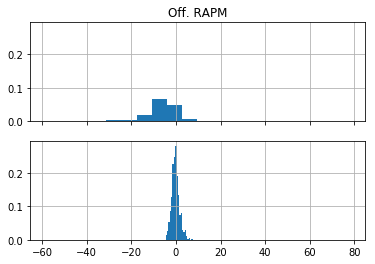

In [25]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
oapm.hist(bins=20, ax=ax[0], normed=True)
ax[0].set_title("Off. APM")
orapm.hist(bins=20, ax=ax[1], normed=True)
ax[0].set_title("Off. RAPM");

## Estimating the Penalization Parameter

We can use a routine cross-validation approach to estimate the penalization parameters that yield improved plus/minus results.  Note: These two cells take several minutes to run and are not required.

In [26]:
alphas = np.linspace(1000, 3000, 21)
rapm_cv = linear_model.RidgeCV(alphas=alphas, fit_intercept=False, cv=5)
rapm_cv.fit(to_coo(stints), net_rtg, sample_weight=net_poss)
print(rapm_cv.alpha_)

2000.0


In [27]:
alphas = np.linspace(1000, 3000, 21)
rapm_off_def_model_cv = linear_model.RidgeCV(alphas=alphas, fit_intercept=False, cv=5)
rapm_off_def_model_cv.fit(to_coo(off_def_stints), off_rtg_above_avg, sample_weight=off_poss)
print(rapm_off_def_model_cv.alpha_)

1600.0
